# Playground

Use this to play around with the code before jumping right into the script!!
Goodluck :)

This is for making the convolutional algorithm from scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#let's use simple data with mnist digits
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
y_train.shape

(60000,)

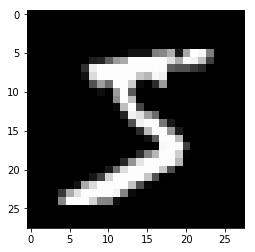

In [5]:
plt.imshow(x_train[0], cmap='gray')

## Part 1 - Convolutional2D

Convolution between image and the filter

In [6]:
class Convolution2D:
    def __init__(self, filter_shape, num_filters):
        self.filter_shape = filter_shape
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, filter_shape[0], filter_shape[0]) # random initialization
        
    def iterate(self, img, filter_shape):
        height, width = img.shape
        
        for i in range(height - 2):
            for j in range(width - 2):
                output = img[i:(i+filter_shape[0]), j:(j+filter_shape[0])]
                yield output, i, j # 'yield' keyword will return any values and continue from the last value returned
    
    def conv2d(self, inputs):
        height, width = inputs.shape
        output = np.zeros((height-2, width-2, self.num_filters)) 
        
        for region, i, j in self.iterate(inputs, self.filter_shape):
            output[i, j] = np.sum(region * self.filters, axis=(1,2))
#             print(region.shape)
#             print(self.filters.shape)
#             print(region * self.filters)
        
        return output

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

convolution = Convolution2D(filter_shape=(3,3), num_filters=8)
output = convolution.conv2d(x_train[0]) # x_train = 28x28 shape
output.shape # output should be 26x26 because of the convolution computation

(26, 26, 8)

## Part 2 - Maxpool2D

In [8]:
class MaxPool2D:
    def iterate(self, img):
        height, width, _ = img.shape
        h = height//2
        w = width//2
        
        for i in range(h):
            for j in range(w):
                new_region = img[(i*2):(i*2+2), (j*2):(j*2+2)]
                yield new_region, i, j
    
    # 2x2 maxpool --> nxn maxpool if possible
    def pool(self, inputs):
        height, width, num_filters = inputs.shape
        output = np.zeros((height//2, width//2, num_filters))
        
        for img_region, i, j in self.iterate(inputs):
            output[i, j] = np.max(img_region, axis=(0,1))
        
        return output

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

convolution = Convolution2D(filter_shape=(3,3), num_filters=8)
maxpool = MaxPool2D()

output = convolution.conv2d(x_train[0]) # x_train = 28x28 shape
output = maxpool.pool(output) # 26x26x8 before pooling
output.shape # should be 13x13x8 after pooling

(13, 13, 8)

## Part 3 - Dense Layer

In [40]:
class Softmax:
    # initialize random weights and zero biases
    def __init__(self, num_features, num_nodes):
        self.weights = np.random.randn(num_features, num_nodes) / num_features
        self.biases = np.zeros(num_nodes)
#         print(self.weights.shape)
#         print(self.biases.shape)
    
    # flattens out the previous layer
    def flatten(self, inputs):
        self.inputs = inputs.flatten()
#         print(self.inputs.shape)
    
    # connects flattened layer with a fully connected layer (dense)
    def dense(self, inputs):
        input_features, nodes = self.weights.shape
        
        z = np.dot(self.inputs, self.weights) + self.biases # z = W . X + b
        a = np.exp(z) # a = g(z)

        return a / np.sum(a, axis=0) # e^a / sum(a)

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

convolution = Convolution2D(filter_shape=(3,3), num_filters=8)
maxpool = MaxPool2D()
softmax = Softmax(13*13*8, 10, activation='softmax') # 13x13 input to softmax from maxpool's output --> 26x26 original size

output = convolution.conv2d(x_train[0]) 
output = maxpool.pool(output)
output = softmax.flatten(output)
output = softmax.dense(output)

print(output.shape)

(10,)


# Part 4 - Forward Propagation

In [13]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [14]:
convolution = Convolution2D(filter_shape=(3,3), num_filters=8)
maxpool = MaxPool2D()
softmax = Softmax(13*13*8, 10, activation='softmax')

In [15]:
def forward_propagation(img, label):
    output = convolution.conv2d(img/255)
    output = maxpool.pool(output)
    output = softmax.flatten(output)
    output = softmax.dense(output)
    
    loss = -np.log(output[label]) # -log(x) --> softmax loss function
    acc = 1 if np.argmax(output) == label else 0 # increase the accuracy if the predicted label = actual label
    
    return output, loss, acc

Let's train the data

In [16]:
total_loss = 0
accuracy = 0

for i, (img, label) in enumerate(zip(x_train[:1000], y_train[:1000])): # let's train first 1000 data for simplicity 
    _, loss, acc = forward_propagation(img, label)
    total_loss += loss
    accuracy += acc
    
    if i % 100 == 0:
        print("Epoch", i, ": Loss= ", total_loss/100, "| Accuracy=", accuracy, "%")
        
        total_loss = 0
        accuracy = 0

Epoch 0 : Loss=  0.023147506817705298 | Accuracy= 0 %
Epoch 100 : Loss=  2.30030483621107 | Accuracy= 10 %
Epoch 200 : Loss=  2.298083537522648 | Accuracy= 14 %
Epoch 300 : Loss=  2.2958402460304286 | Accuracy= 17 %
Epoch 400 : Loss=  2.297366337322565 | Accuracy= 18 %
Epoch 500 : Loss=  2.297146552203074 | Accuracy= 18 %
Epoch 600 : Loss=  2.2987770967213463 | Accuracy= 12 %
Epoch 700 : Loss=  2.296604836276269 | Accuracy= 11 %
Epoch 800 : Loss=  2.296966659245608 | Accuracy= 16 %
Epoch 900 : Loss=  2.298798865838092 | Accuracy= 11 %


FINALLY DONEEEEE!!!! but still no backprop :(

TBD:
1. backpropagation, obviously --> https://becominghuman.ai/back-propagation-in-convolutional-neural-networks-intuition-and-code-714ef1c38199
2. padding, stride
3. ...

### Padding

Padding is useful when we want to keep the resolution of the image (does not shrink after the convolution)

In [6]:
def padding(img, pad):
    img_pad = np.pad(img, ((pad, pad), (pad,pad)), 'constant', constant_values=0)
    
    return img_pad

x.shape = (28, 28)
x_pad.shape = (30, 30)
x[1,1] = [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253
  159  50   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252
  252 237   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239
  233 252  57   6   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202
   84 252 253 122   0   0   0   0   0   0]
 [  0   0   0

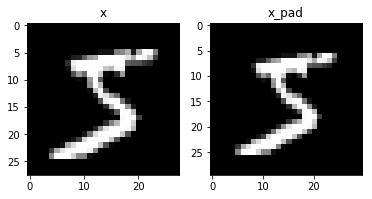

In [7]:
x_pad = padding(x_train[0], 1)
print ("x.shape =", x_train[0].shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x_train[1])
print ("x_pad[1,1] =", x_pad[1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x_train[0,:,:], cmap='gray')
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[:,:], cmap='gray')

Notice that the image with x_pad label looks kind of zoomed out than the original image, this is due to the zero padding that adds more pixel density to the image

Now let's implement it in the Convolution2D class

In [155]:
class Convolution2D:
    def __init__(self, filter_shape, num_filters, padding, stride):
        self.filter_shape = filter_shape
        self.num_filters = num_filters
        self.padding = padding
        self.stride = stride
        self.filters = np.random.randn(num_filters, filter_shape[0], filter_shape[0]) # random initialization
        
    def iterate(self, img, filter_shape):
        height, width = img.shape
        height = int((height + 2 * self.pad_size - self.filter_shape[0]) / self.stride) + 1
        width = int((width + 2 * self.pad_size - self.filter_shape[0]) / self.stride) + 1
        # check for odd heights and widths
        if height % 2 != 0 and width % 2 != 0:
            height += 1
            width += 1
#         print(height)
#         print(width)
#         print(filter_shape[0]-1)
        
        for i in range(height-(filter_shape[0]-1)):
            for j in range(width-(filter_shape[0]-1)):
#                 i_start = i * self.stride
#                 i_end = i_start + filter_shape[0]
#                 j_start = j * self.stride
#                 j_end = j_start * filter_shape[0]
#                 output = img[i_start:i_end, j_start:j_end]
                output = img[i*self.stride:(i*self.stride+filter_shape[0]), j*self.stride:(j*self.stride+filter_shape[0])]
#                 print(output, i, j)
                yield output, i, j # 'yield' keyword will return any values and continue from the last value returned
    
    def conv2d(self, inputs):
#         print("Before padding: ", inputs.shape)
        self.last_input = inputs # cache the last input for backpropagation
    
        # padding
        if(self.padding.lower() == 'same'): # same padding
            height, width = inputs.shape
            
            pad_size = int(((height * self.stride) - height + self.filter_shape[0] - 1) / 2)
            self.pad_size = pad_size

            inputs = padding(inputs, pad_size) # apply padding according to the pad_size
            height, width = inputs.shape # reinitialize height and width with padded image

            new_height = int((height + 2 * pad_size - self.filter_shape[0]) / self.stride) + 1
            new_width = int((width + 2 * pad_size - self.filter_shape[0]) / self.stride) + 1
            # check for odd heights and widths
            if new_height % 2 != 0 and new_width % 2 != 0:
                new_height += 1
                new_width += 1
                
            output = np.zeros((new_height, new_width, self.num_filters))
            
        elif(self.padding.lower() == 'valid'): # valid/no padding
            height, width = inputs.shape
            self.pad_size = 0
            output = np.zeros((height-(self.filter_shape[0]-1), width-(self.filter_shape[0]-1), self.num_filters))
            
#         print("After padding: ", inputs.shape)
        
        for region, i, j in self.iterate(inputs, self.filter_shape):
            output[i, j] = np.sum(region * self.filters, axis=(1,2))
        
#         print("After convolution: ", output.shape)
        return output

    def back_propagation(self, dL, learning_rate):
        dL_filters = np.zeros(self.filters.shape)
        
        for img_region, i, j in self.iterate(self.last_input, self.filter_shape):
            for k in range(self.num_filters):
                dL_filters[k] += dL[i, j, k] * img_region
        
        # don't forget to update the filters
        self.filters -= learning_rate * dL_filters
        
        return None

In [156]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

convolution = Convolution2D(filter_shape=(5,5), num_filters=8, stride=1, padding='same')
output = convolution.conv2d(x_train[0]) # x_train = nxn shape
output.shape # output should be nxn because of padding

(32, 32, 8)

In [157]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

convolution = Convolution2D(filter_shape=(6,6), num_filters=8, stride=1, padding='same')
output = convolution.conv2d(x_train[0]) # x_train = nxn shape
output.shape # output should be nxn because of padding

(32, 32, 8)

In [158]:
class MaxPool2D:
    def __init__(self, pool_size):
        self.pool_size = pool_size
    
    def iterate(self, img):
        height, width, _ = img.shape
        h = height//self.pool_size
        w = width//self.pool_size
        
        for i in range(h):
            for j in range(w):
                new_region = img[(i*self.pool_size):(i*self.pool_size+self.pool_size), 
                                 (j*self.pool_size):(j*self.pool_size+self.pool_size)]
                yield new_region, i, j
    
    def pool(self, inputs):
        self.last_input = inputs # cache the last input for backpropagation
        
        height, width, num_filters = inputs.shape
        output = np.zeros((height//self.pool_size, width//self.pool_size, num_filters))
        
        for img_region, i, j in self.iterate(inputs):
            output[i, j] = np.max(img_region, axis=(0,1))
        
#         print("After pooling: ", output.shape)
        return output
    
    # backpropagation
    def back_propagation(self, dL_output):
        dL_input = np.zeros((self.last_input.shape))
        
        for img_region, i, j in self.iterate(self.last_input):
            height, width, num_filters = img_region.shape
            # find the max value for each region
            maxi = np.max(img_region, axis=(0,1))
            
            for k in range(height):
                for l in range(width):
                    for m in range(num_filters):
                        if img_region[k, l, m] == maxi[m]: # if the max values match, copy the gradient
                            dL_input[i*2+k, j*2+l, m] = dL_output[i, j, m]
        return dL_input

In [159]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

convolution = Convolution2D(filter_shape=(3,3), num_filters=8, padding='same', stride=1)
maxpool = MaxPool2D(pool_size=2)

output = convolution.conv2d(x_train[0]) # x_train = 28x28 shape
output = maxpool.pool(output) # 26x26x8 before pooling
output.shape # should be 13x13x8 after pooling

(15, 15, 8)

In [160]:
class Softmax:
    # initialize random weights and zero biases
    def __init__(self, num_features, num_nodes, activation):
        self.weights = np.random.randn(num_features, num_nodes) / num_features
        self.biases = np.zeros(num_nodes)
        self.activation = activation
#         print(self.weights.shape)
#         print(self.biases.shape)
    
    # flattens out the previous layer
    def flatten(self, inputs):
        self.inputs = inputs.flatten()
#         print(self.inputs.shape)
    
    # connects flattened layer with a fully connected layer (dense)
    def dense(self, inputs):
        self.last_input_shape = inputs.shape # cache the last input shape BEFORE FLATTENING
        
        inputs = inputs.flatten() # flatten
        self.last_input = inputs # cache the last input shape AFTER FLATTENING
        input_features, nodes = self.weights.shape
        
        z = np.dot(inputs, self.weights) + self.biases # z = W . X + b
        self.z = z # cache z for backpropagation
        
        if(self.activation.lower() == 'softmax'):    
            a = np.exp(z) # a = g(z)
            return a / np.sum(a, axis=0) # e^a / sum(a)
        
        elif(self.activation.lower() == 'relu'):
            return max(0, z)
    
    # forward propagate phase
    def forward_propagation(self, img, label, output, reg_lambda):
        # -log(x) --> softmax loss function
        loss = (-np.log(output[label])) + (1/2 * reg_lambda * np.sum(self.weights ** 2)) # + regularization term
        acc = 1 if np.argmax(output) == label else 0 # increase the accuracy if the predicted label = actual label

        return output, loss, acc
    
    def back_propagation(self, dL, learning_rate, reg_lambda):
        for i, grad in enumerate(dL):
            if grad == 0: continue; # ignores 0 gradient
            
            exp_total = np.exp(self.z) # total of e^
            exp_sum = np.sum(exp_total) # sum of e^
            
            # gradients of z against totals
            dz = -exp_total[i] * exp_total / (exp_sum ** 2)
            dz[i] = exp_total[i] * (exp_sum - exp_total[i]) / (exp_sum ** 2)
            
            # gradients of totals against weights, biases, inputs
            dt_dw = self.last_input
            dt_db = 1
            dt_di = self.weights
            
            # gradients of loss against totals
            dL_dt = grad * dz
            
            # gradients of loss against weights, biases, and inputs
            dL_dw = np.dot(dt_dw[np.newaxis].T, dL_dt[np.newaxis])
            dL_db = dL_dt * dt_db
            dL_di = np.dot(dt_di, dL_dt)
            
            # add the regularization term
            dL_dw += reg_lambda * self.weights
            
            # update weights and biases
            self.weights -= learning_rate * dL_dw
            self.biases -= learning_rate * dL_db
            
            return dL_di.reshape(self.last_input_shape)

In [161]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

convolution = Convolution2D(filter_shape=(3,3), num_filters=8, padding='same', stride=1)
maxpool = MaxPool2D(pool_size=2)
temp = convolution.conv2d(x_train[0]/255)
temp = maxpool.pool(temp)
tmp_size = temp.shape
softmax = Softmax(tmp_size[0]*tmp_size[1]*tmp_size[2], 10, activation='softmax')

output = convolution.conv2d(x_train[0]/255) 
output = maxpool.pool(output)
# output = softmax.flatten(output)
output = softmax.dense(output)

# print("After flattening & dense: ", output.shape)

In [172]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
convolution = Convolution2D(filter_shape=(3,3), num_filters=8, padding='valid', stride=1)
maxpool = MaxPool2D(pool_size=2)
temp = convolution.conv2d(x_train[0]/255)
temp = maxpool.pool(temp)
tmp_shape = temp.shape
softmax = Softmax(tmp_shape[0]*tmp_shape[1]*tmp_shape[2], 10, activation='softmax')

In [175]:
def build_model(image):
    # initialize the architecture
    model = convolution.conv2d(image/255)
    model = maxpool.pool(model)
    model = softmax.dense(model)
    
    return model

def train(img, label, learning_rate):

    train_model = build_model(img)
#     model = convolution.conv2d(img/255)
#     model = maxpool.pool(model)
#     model = softmax.dense(model)
    # forward propagation step
    output, loss, acc = softmax.forward_propagation(img, label, train_model, reg_lambda=1e-3)
    
    # initial gradient
    grad = np.zeros(10) # 10 different classes
    grad[label] = -1 / output[label]
    
    # back propagation
    grad = softmax.back_propagation(grad, learning_rate, reg_lambda=1e-3)
    grad = maxpool.back_propagation(grad)
    grad = convolution.back_propagation(grad, learning_rate)
    
    return loss, acc


In [176]:
NUM_EPOCHS = 3
learning_rate = 0.001

for epoch in range(NUM_EPOCHS):  
    print("============= EPOCH", epoch+1, "=============")
    total_loss = 0
    accuracy = 0

    for i, (img, label) in enumerate(zip(x_train[:1000], y_train[:1000])): # let's train first 1000 data for simplicity 
        # build the complete model
        if i % 100 == 0 and i != 0:
            print("Step", i, ": Loss= ", total_loss/100, "| Accuracy=", accuracy, "%")

            total_loss = 0
            accuracy = 0
        loss, acc = train(img, label, learning_rate)
        total_loss += loss
        accuracy += acc

============= EPOCH 1 =============
Step 100 : Loss=  1.6988826150822467 | Accuracy= 42 %
Step 200 : Loss=  1.0434527990422775 | Accuracy= 73 %
Step 300 : Loss=  0.7989083488260096 | Accuracy= 75 %
Step 400 : Loss=  0.5927439915423942 | Accuracy= 80 %
Step 500 : Loss=  0.6441426952769082 | Accuracy= 80 %
Step 600 : Loss=  0.7626077190057743 | Accuracy= 76 %
Step 700 : Loss=  0.7338089215443242 | Accuracy= 82 %
Step 800 : Loss=  0.5096937622098161 | Accuracy= 84 %
Step 900 : Loss=  0.65786390182228 | Accuracy= 81 %


In [179]:
# test the model
def test(X_test, y_test):
    loss = 0
    accuracy = 0
    for img, label in zip(X_test, y_test):
        test_model = build_model(img)
#         model = convolution.conv2d(img/255)
#         model = maxpool.pool(model)
#         model = softmax.dense(model)
        _, l, acc = softmax.forward_propagation(img, label, test_model, reg_lambda=1e-3)
        loss += l
        accuracy += acc

    print("Test Loss: ", loss/len(X_test))
    print("Test Accuracy: ", accuracy/len(y_test))

In [180]:
test(x_test[:1000], y_test[:1000])

Test Loss:  0.6509955960124785
Test Accuracy:  0.774


Now it also works with padding and stride!

It's much closer to the accuracy from keras' model, because now we use the regularization term

## Part 5 - Back Propagation (Softmax)

In [73]:
class Softmax:
    # initialize random weights and zero biases
    def __init__(self, num_features, num_nodes):
        self.weights = np.random.randn(num_features, num_nodes) / num_features
        self.biases = np.zeros(num_nodes)
#         print(self.weights.shape)
#         print(self.biases.shape)
    
    # move flatten inside the dense function
#     def flatten(self, inputs):
#         self.inputs = inputs.flatten()
#         print(self.inputs.shape)
    
    # connects flattened layer with a fully connected layer (dense)
    def dense(self, inputs):
        self.last_input_shape = inputs.shape # cache the last input shape BEFORE FLATTENING
        
        inputs = inputs.flatten()
        self.last_input = inputs # cache the last input shape AFTER FLATTENING
        input_features, nodes = self.weights.shape
        
        z = np.dot(inputs, self.weights) + self.biases # z = W . X + b
        self.z = z # cache z for backpropagation
        a = np.exp(z) # a = g(z)
        
        return a / np.sum(a, axis=0) # e^a / sum(a)
    
    def back_propagation(self, dL, learning_rate):
        for i, grad in enumerate(dL):
            if grad == 0: continue; # ignores 0 gradient
            
            exp_total = np.exp(self.z) # total of e^
            exp_sum = np.sum(exp_total) # sum of e^
            
            # gradients of z against totals
            dz = -exp_total[i] * exp_total / (exp_sum ** 2)
            dz[i] = exp_total[i] * (exp_sum - exp_total[i]) / (exp_sum ** 2)
            
            # gradients of totals against weights, biases, inputs
            dt_dw = self.last_input
            dt_db = 1
            dt_di = self.weights
            
            # gradients of loss against totals
            dL_dt = grad * dz
            
            # gradients of loss against weights, biases, and inputs
            dL_dw = np.dot(dt_dw[np.newaxis].T, dL_dt[np.newaxis])
            dL_db = dL_dt * dt_db
            dL_di = np.dot(dt_di, dL_dt)
            
            # update weights and biases
            self.weights -= learning_rate * dL_dw
            self.biases -= learning_rate * dL_db
            
            return dL_di.reshape(self.last_input_shape)

Now Let's try the backpropagation

In [130]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [131]:
convolution = Convolution2D(filter_shape=(3,3), num_filters=8)
maxpool = MaxPool2D()
softmax = Softmax(13*13*8, 10)

TypeError: __init__() missing 1 required positional argument: 'pool_size'

In [76]:
def forward_propagation(img, label):
    output = convolution.conv2d(img/255)
    output = maxpool.pool(output)
#     output = softmax.flatten(output)
    output = softmax.dense(output)
    
    loss = -np.log(output[label]) # -log(x) --> softmax loss function
    acc = 1 if np.argmax(output) == label else 0 # increase the accuracy if the predicted label = actual label
    
    return output, loss, acc

In [49]:
def train(img, label, learning_rate):
    # forward propagation
    output, loss, acc = forward_propagation(img, label)
    
    # initial gradient
    grad = np.zeros(10) # 10 different classes
    grad[label] = -1 / output[label]
    
    # back propagation
    grad = softmax.back_propagation(grad, learning_rate)
    
    return loss, acc

In [50]:
l = 0
acc = 0

for i, (img, label) in enumerate(zip(x_train[:1000], y_train[:1000])):
    if i % 100 == 0:
        print("Epoch #%d: Loss=%.3f | Accuracy=%.2f" % (i, l/100, acc))
        l = 0
        acc = 0
    loss, accuracy = train(img, label, learning_rate=0.005)
    l += loss
    acc += accuracy

Epoch #0: Loss=0.000 | Accuracy=0.00
Epoch #100: Loss=1.474 | Accuracy=51.00
Epoch #200: Loss=0.839 | Accuracy=74.00
Epoch #300: Loss=0.735 | Accuracy=78.00
Epoch #400: Loss=0.503 | Accuracy=86.00
Epoch #500: Loss=0.604 | Accuracy=82.00
Epoch #600: Loss=0.723 | Accuracy=77.00
Epoch #700: Loss=0.685 | Accuracy=83.00
Epoch #800: Loss=0.434 | Accuracy=87.00
Epoch #900: Loss=0.604 | Accuracy=81.00


WOHOOOO IT'S WORKINGGGG

## Part 6 - Back Propagation (MaxPool & Conv2D)

In [77]:
class MaxPool2D:
    def iterate(self, img):
        height, width, _ = img.shape
        h = height//2
        w = width//2
        
        for i in range(h):
            for j in range(w):
                new_region = img[(i*2):(i*2+2), (j*2):(j*2+2)]
                yield new_region, i, j
    
    # 2x2 maxpool --> nxn maxpool if possible
    def pool(self, inputs):
        self.last_input = inputs # cache last input for backpropagation
        
        height, width, num_filters = inputs.shape
        output = np.zeros((height//2, width//2, num_filters))
        
        for img_region, i, j in self.iterate(inputs):
            output[i, j] = np.max(img_region, axis=(0,1))
        
        return output
    
    def back_propagation(self, dL_output):
        dL_input = np.zeros((self.last_input.shape))
        
        for img_region, i, j in self.iterate(self.last_input):
            height, width, num_filters = img_region.shape
            # find the max value for each region
            maxi = np.max(img_region, axis=(0,1))
            
            for k in range(height):
                for l in range(width):
                    for m in range(num_filters):
                        if img_region[k, l, m] == maxi[m]: # if the max values match, copy the gradient
                            dL_input[i*2+k, j*2+l, m] = dL_output[i, j, m]
        return dL_input

In [78]:
class Convolution2D:
    def __init__(self, filter_shape, num_filters):
        self.filter_shape = filter_shape
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, filter_shape[0], filter_shape[0]) # random initialization
        
    def iterate(self, img, filter_shape):
        height, width = img.shape
        
        for i in range(height - 2):
            for j in range(width - 2):
                output = img[i:(i+filter_shape[0]), j:(j+filter_shape[0])]
                yield output, i, j # 'yield' keyword will return any values and continue from the last value returned
    
    def conv2d(self, inputs):
        self.last_input = inputs # cache the last input for backpropagation
        
        height, width = inputs.shape
        output = np.zeros((height-2, width-2, self.num_filters)) 
        
        for region, i, j in self.iterate(inputs, self.filter_shape):
            output[i, j] = np.sum(region * self.filters, axis=(1,2))
#             print(region * self.filters)
        
        return output
    
    def back_propagation(self, dL, learning_rate):
        dL_filters = np.zeros(self.filters.shape)
        
        for img_region, i, j in self.iterate(self.last_input, self.filter_shape):
            for k in range(self.num_filters):
                dL_filters[k] += dL[i, j, k] * img_region
        
        # don't forget to update the filters
        self.filters -= learning_rate * dL_filters
        
        return None

## Part 7 - Putting it altogether

Now let's put all together into 1 model and train it

In [79]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [80]:
conv = Convolution2D(num_filters=8, filter_shape=(3,3))
pooling = MaxPool2D()
softmax = Softmax(13*13*8, 10)

In [81]:
def forward_propagation(img, label):
    # define the model
    model = conv.conv2d(img/255)
    model = pooling.pool(model)
    model = softmax.dense(model)
    
    # calculate loss
    loss = -np.log(model[label])
    acc = 1 if np.argmax(model) == label else 0
    
    return model, loss, acc

In [82]:
def train(img, label, learning_rate=0.005):
    # forward propagation
    output, loss, acc = forward_propagation(img, label) # test with 1000 images
    # initial gradient
    grad = np.zeros(10)
    grad[label] = -1 / output[label]
    # back propagation
    grad = softmax.back_propagation(grad, learning_rate)
#     print(grad.shape)
    grad = pooling.back_propagation(grad)
    grad = conv.back_propagation(grad, learning_rate)
    
    return loss, acc

In [83]:
# train the model
for epoch in range(3):
    print("EPOCH #", epoch)
    
    loss = 0
    accuracy = 0
    for i, (img, label) in enumerate(zip(x_train[:1000], y_train[:1000])):
        if i % 100 == 0:
            print("Step #%d: Loss=%.3f | Accuracy=%d" % (i, loss/100, accuracy))
            loss = 0
            accuracy = 0
            
        l, acc = train(img, label)
        loss += l
        accuracy += acc

EPOCH # 0
Step #0: Loss=0.000 | Accuracy=0
Step #100: Loss=1.599 | Accuracy=44
Step #200: Loss=0.930 | Accuracy=71
Step #300: Loss=0.866 | Accuracy=75
Step #400: Loss=0.524 | Accuracy=83
Step #500: Loss=0.639 | Accuracy=78
Step #600: Loss=0.813 | Accuracy=77
Step #700: Loss=0.825 | Accuracy=82
Step #800: Loss=0.520 | Accuracy=82
Step #900: Loss=0.726 | Accuracy=80
EPOCH # 1
Step #0: Loss=0.000 | Accuracy=0
Step #100: Loss=0.294 | Accuracy=92
Step #200: Loss=0.413 | Accuracy=88
Step #300: Loss=0.366 | Accuracy=87
Step #400: Loss=0.186 | Accuracy=94


KeyboardInterrupt: 

In [58]:
# test the model
loss = 0
accuracy = 0
for img, label in zip(x_test[:1000], y_test[:1000]):
    _, l, acc = forward_propagation(img, label)
    loss += l
    accuracy += acc
            
print("Test Loss: ", loss/len(x_test[:1000]))
print("Test Accuracy: ", accuracy/len(x_test[:1000]))

Test Loss:  0.641302939500671
Test Accuracy:  0.804


## Keras Model

Now let's compare our scratch model with keras built-in library model

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.utils import to_categorical

Using TensorFlow backend.


In [45]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [46]:
# normalization
x_train = x_train/255
x_test = x_test/255

# reshape
x_train = np.reshape(x_train, ((60000,28,28,1)))
x_test = np.reshape(x_test, (10000,28, 28,1))

# one-hot encoding for label y
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [47]:
y_test.shape

(10000, 10)

In [48]:
# create the model with the same hyperparameters as the scratch model
keras_model = Sequential()
keras_model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', input_shape=(28,28,1)))
keras_model.add(MaxPool2D(pool_size=2))

keras_model.add(Flatten())
keras_model.add(Dense(10, activation='softmax'))

keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # optimizer is not yet implemented
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                15690     
Total params: 15,770
Trainable params: 15,770
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = keras_model.fit(x_train[:1000], y_train[:1000], validation_split=0.33, batch_size=1, epochs=3)

Train on 669 samples, validate on 331 samples
Epoch 1/3
669/669 [==============================] - 6s 8ms/step - loss: 0.9652 - acc: 0.7175 - val_loss: 0.6049 - val_acc: 0.8066
Epoch 2/3
669/669 [==============================] - 5s 7ms/step - loss: 0.3690 - acc: 0.8804 - val_loss: 0.5349 - val_acc: 0.8671
Epoch 3/3
669/669 [==============================] - 5s 7ms/step - loss: 0.2404 - acc: 0.9268 - val_loss: 0.5595 - val_acc: 0.8308


Great!! it is similar with our scratch model achieving 94% accuracy! :)

In [25]:
keras_model.evaluate(x_test[:1000], y_test[:1000])

1000/1000 [==============================] - 0s 213us/step


[0.49879764223098755, 0.84]

However, in the test set, keras outperforms our scratch model with 5-10% better accuracy. This is maybe due to the adam optimizer. Still, not bad for a scratch model though! :)

Now let's analyse the result from the model

In [41]:
def show_loss_graph(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [42]:
def show_acc_graph(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Training Accuracy vs validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [43]:
# shows key metrics from the fit model
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


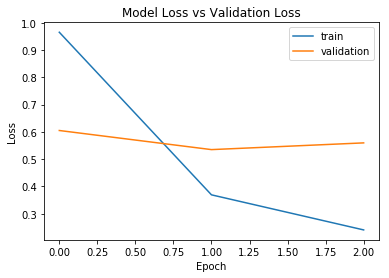

In [50]:
show_loss_graph(history)

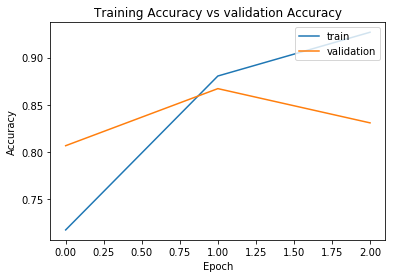

In [51]:
show_acc_graph(history)

## Mini-batch Gradient Descent vs SGD vs Batch Gradient Descent

### Mini-Batch

In [62]:
# create the model with the same hyperparameters as the scratch model
batch_model = Sequential()
batch_model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', input_shape=(28,28,1)))
batch_model.add(MaxPool2D(pool_size=2))

batch_model.add(Flatten())
batch_model.add(Dense(10, activation='softmax'))

batch_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # optimizer is not yet implemented
batch_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                15690     
Total params: 15,770
Trainable params: 15,770
Non-trainable params: 0
_________________________________________________________________


In [63]:
mini_batch_history = batch_model.fit(x_train[:1000], y_train[:1000], validation_split=0.2, batch_size=32, epochs=10)

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 1s 2ms/step - loss: 2.0290 - acc: 0.4012 - val_loss: 1.7092 - val_acc: 0.7550
Epoch 2/10
800/800 [==============================] - 1s 775us/step - loss: 1.3665 - acc: 0.8113 - val_loss: 1.0961 - val_acc: 0.8350
Epoch 3/10
800/800 [==============================] - 1s 845us/step - loss: 0.8168 - acc: 0.8325 - val_loss: 0.7273 - val_acc: 0.8450
Epoch 4/10
800/800 [==============================] - 1s 644us/step - loss: 0.5643 - acc: 0.8600 - val_loss: 0.5950 - val_acc: 0.8500
Epoch 5/10
800/800 [==============================] - 1s 669us/step - loss: 0.4421 - acc: 0.8800 - val_loss: 0.5410 - val_acc: 0.8500
Epoch 6/10
800/800 [==============================] - 0s 609us/step - loss: 0.3723 - acc: 0.9025 - val_loss: 0.5172 - val_acc: 0.8600
Epoch 7/10
800/800 [==============================] - 0s 613us/step - loss: 0.3201 - acc: 0.9138 - val_loss: 0.4770 - val_acc: 0.8600
Epoch 8/10
800/800

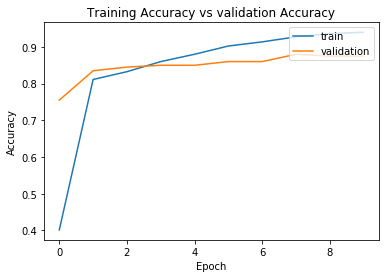

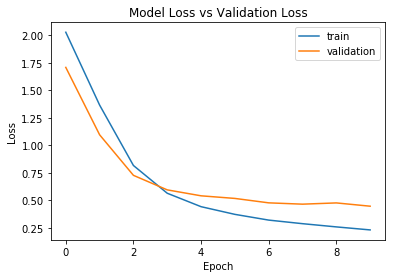

In [64]:
show_acc_graph(mini_batch_history)
show_loss_graph(mini_batch_history)

### SGD

In [65]:
# reinitialize model
batch_model = Sequential()
batch_model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', input_shape=(28,28,1)))
batch_model.add(MaxPool2D(pool_size=2))

batch_model.add(Flatten())
batch_model.add(Dense(10, activation='softmax'))

batch_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # optimizer is not yet implemented
batch_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                15690     
Total params: 15,770
Trainable params: 15,770
Non-trainable params: 0
_________________________________________________________________


In [66]:
sgd_batch_history = batch_model.fit(x_train[:1000], y_train[:1000], validation_split=0.2, batch_size=1, epochs=10)

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 6s 8ms/step - loss: 0.9337 - acc: 0.7087 - val_loss: 0.5654 - val_acc: 0.8300
Epoch 2/10
800/800 [==============================] - 5s 6ms/step - loss: 0.3428 - acc: 0.8987 - val_loss: 0.5523 - val_acc: 0.8350
Epoch 3/10
800/800 [==============================] - 5s 7ms/step - loss: 0.2491 - acc: 0.9350 - val_loss: 0.5637 - val_acc: 0.8550
Epoch 4/10
800/800 [==============================] - 5s 6ms/step - loss: 0.1650 - acc: 0.9462 - val_loss: 0.5012 - val_acc: 0.8550
Epoch 5/10
800/800 [==============================] - 5s 7ms/step - loss: 0.1159 - acc: 0.9662 - val_loss: 0.6410 - val_acc: 0.8300
Epoch 6/10
800/800 [==============================] - 5s 6ms/step - loss: 0.0849 - acc: 0.9750 - val_loss: 0.5602 - val_acc: 0.8550
Epoch 7/10
800/800 [==============================] - 5s 6ms/step - loss: 0.0510 - acc: 0.9875 - val_loss: 0.6330 - val_acc: 0.8350
Epoch 8/10
800/800 [==========

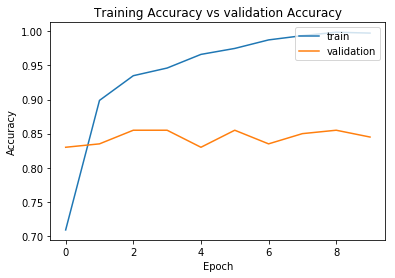

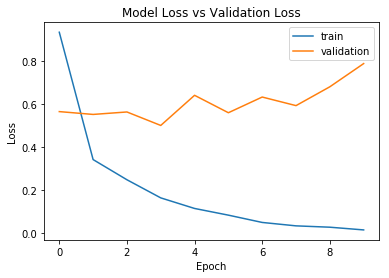

In [67]:
show_acc_graph(sgd_batch_history)
show_loss_graph(sgd_batch_history)

### Batch Gradient Descent

In [68]:
# reinitialize model
batch_model = Sequential()
batch_model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', input_shape=(28,28,1)))
batch_model.add(MaxPool2D(pool_size=2))

batch_model.add(Flatten())
batch_model.add(Dense(10, activation='softmax'))

batch_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # optimizer is not yet implemented
batch_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                15690     
Total params: 15,770
Trainable params: 15,770
Non-trainable params: 0
_________________________________________________________________


In [69]:
batch_history = batch_model.fit(x_train[:1000], y_train[:1000], validation_split=0.2, batch_size=1000, epochs=10)

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 1s 2ms/step - loss: 2.3071 - acc: 0.0800 - val_loss: 2.2719 - val_acc: 0.1050
Epoch 2/10
800/800 [==============================] - 0s 312us/step - loss: 2.2849 - acc: 0.0900 - val_loss: 2.2480 - val_acc: 0.1300
Epoch 3/10
800/800 [==============================] - 0s 294us/step - loss: 2.2595 - acc: 0.1150 - val_loss: 2.2206 - val_acc: 0.2050
Epoch 4/10
800/800 [==============================] - 0s 300us/step - loss: 2.2304 - acc: 0.1650 - val_loss: 2.1933 - val_acc: 0.2650
Epoch 5/10
800/800 [==============================] - 0s 313us/step - loss: 2.2013 - acc: 0.2438 - val_loss: 2.1660 - val_acc: 0.3350
Epoch 6/10
800/800 [==============================] - 0s 309us/step - loss: 2.1721 - acc: 0.3388 - val_loss: 2.1394 - val_acc: 0.4500
Epoch 7/10
800/800 [==============================] - 0s 309us/step - loss: 2.1435 - acc: 0.4313 - val_loss: 2.1117 - val_acc: 0.5300
Epoch 8/10
800/800

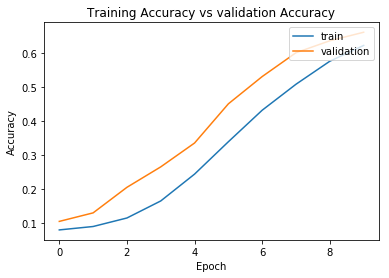

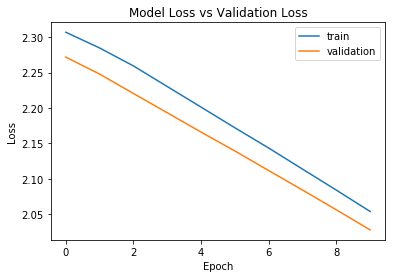

In [70]:
show_acc_graph(batch_history)
show_loss_graph(batch_history)